In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.15.0'

In [3]:

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#### Import Packages

In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input
import cv2

# Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# To define Loss
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon

In [5]:

np_load_old = np.load

np.load = lambda *a,**k: np_load_old(*a, allow_pickle = True, **k)

face_data = np.load('/content/drive/MyDrive/Images.npy')

In [6]:
face_data.shape

(393, 2)

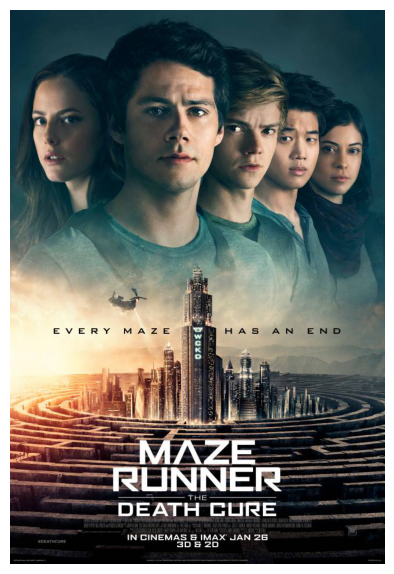

In [7]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(face_data[10][0])
plt.show()

In [8]:
ALPHA = 1

IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

#### Create features and labels


*   Here feature is the image
*   The label is the mask
*   Images will be stored in "X" array
*   Masks will be stored in "masks" array





In [9]:
masks = np.zeros((int(face_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(face_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(face_data.shape[0]):
  img = face_data[index][0]
  img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
  try:
    img = img[:, :, :3]
  except:
    continue
  X[index] = preprocess_input(np.array(img, dtype = np.float32))
  for i in face_data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_HEIGHT)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_WIDTH)
    masks[index][y1:y2, x1:x2] = 1

#### Print the shape of X and mask array

In [10]:
X.shape

(393, 224, 224, 3)

In [11]:
masks.shape

(393, 224, 224)

#### Print a sample training image, image array and its mask

Print the image and image array

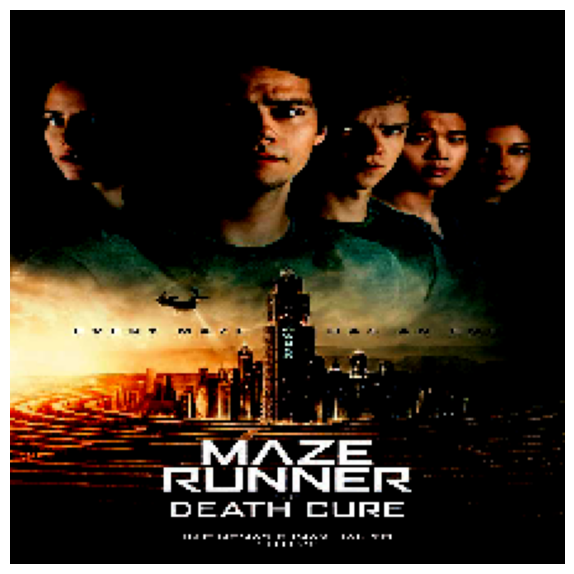

In [12]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

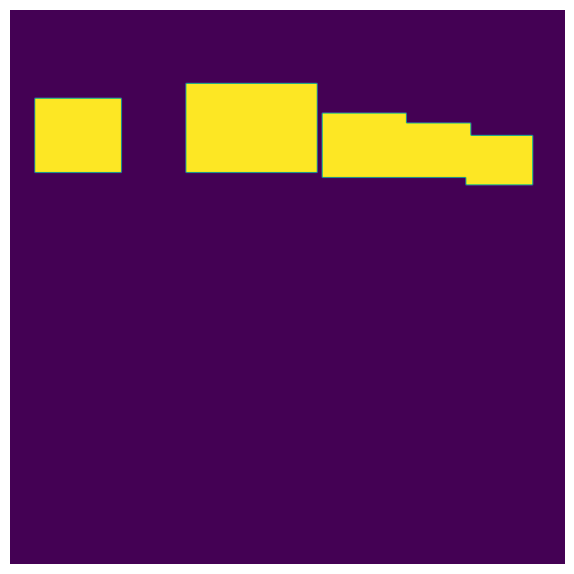

In [13]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

#### Create the model
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers

In [14]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output

    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)

    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

#### Call the create_model function

In [15]:
model = create_model(True)

17225924/17225924 [==============================] - 0s 0us/step


#### Print model summary

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)         128       ['conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['conv1_bn[0][0]']        

#### Define dice coefficient function


*   Create a function to calculate dice coefficient



In [17]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

#### Define loss function

In [18]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

#### Compile the model
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [19]:
adam = Adam(lr = 1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None,  amsgrad = False)
model.compile(loss = loss, optimizer = adam, metrics = [dice_coefficient])

#### Define callbacks
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [20]:
checkpoint = ModelCheckpoint('model_{epoch:02d}.h5', monitor = 'loss', verbose = 1, save_best_only = True, save_weights_only = True, mode = 'min', save_freq = 1)
stop = EarlyStopping(monitor = 'loss', patience = 5, mode = 'min')
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 5, min_lr = 1e-6, verbose = 1, mode = 'min')

#### Split the data into training and testing
- 400 images in training
- 9 images in testing data

In [21]:
X = np.where(X == None, 0, X)
masks = np.where(masks == None, 0, masks)
X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size = 0.022, shuffle = False)

In [22]:
print('Number of images in training data = ', X_train.shape[0])

Number of images in training data =  384


In [23]:
print('Number of images in testing data = ', X_test.shape[0])

Number of images in testing data =  9


In [24]:
print('Numner of labels in training data = ', y_train.shape[0])

Numner of labels in training data =  384


In [25]:
print('Numner of labels in testing data = ', y_test.shape[0])

Numner of labels in testing data =  9


In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [27]:
model.fit(X_train, y_train, epochs = 10, batch_size = 1, callbacks = [checkpoint, reduce_lr, stop], validation_data = (X_test, y_test))

Streaming output truncated to the last 5000 lines.
195/384 [==============>...............] - ETA: 7:15 - loss: 138.0440 - accuracy: 0.0011
Epoch 4: loss did not improve from 19.84186
196/384 [==============>...............] - ETA: 7:13 - loss: 138.0455 - accuracy: 0.0011
Epoch 4: loss did not improve from 19.84186
197/384 [==============>...............] - ETA: 7:11 - loss: 138.0555 - accuracy: 0.0011
Epoch 4: loss did not improve from 19.84186
198/384 [==============>...............] - ETA: 7:08 - loss: 138.6009 - accuracy: 0.0011
Epoch 4: loss did not improve from 19.84186
199/384 [==============>...............] - ETA: 7:06 - loss: 138.2966 - accuracy: 0.0011
Epoch 4: loss did not improve from 19.84186
200/384 [==============>...............] - ETA: 7:03 - loss: 138.2724 - accuracy: 0.0011
Epoch 4: loss did not improve from 19.84186
201/384 [==============>...............] - ETA: 7:01 - loss: 139.5911 - accuracy: 0.0014
Epoch 4: loss did not improve from 19.84186
202/384 [=========

In [28]:
model.evaluate(X_test, y_test, verbose = 1)

1/1 [==============================] - 5s 5s/step - loss: 112.1829 - accuracy: 0.0000e+00


[112.18287658691406, 0.0]

#### Get the predicted mask for a sample image

In [30]:

WEIGHTS_FILE = "/content/model_01.h5"
learned_model = create_model()
learned_model.load_weights(WEIGHTS_FILE)
y_pred = learned_model.predict(X_test, verbose = 1)

1/1 [==============================] - 7s 7s/step


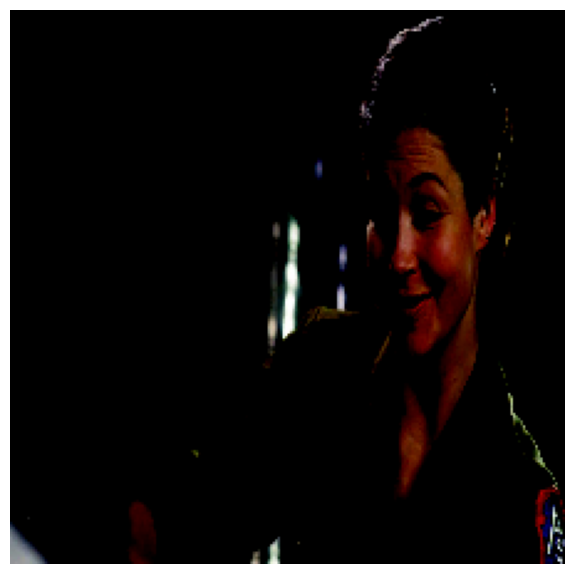

In [31]:

n = 5
image = cv2.resize(X_test[n], dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
pred_mask = cv2.resize(1.0 * (y_pred[n] > 0.1), (IMAGE_WIDTH, IMAGE_HEIGHT))

image2 = image
image2[:, :, 0] = pred_mask * image[:, :, 0]
image2[:, :, 1] = pred_mask * image[:, :, 1]
image2[:, :, 2] = pred_mask * image[:, :, 2]
out_image = image2

fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(out_image)

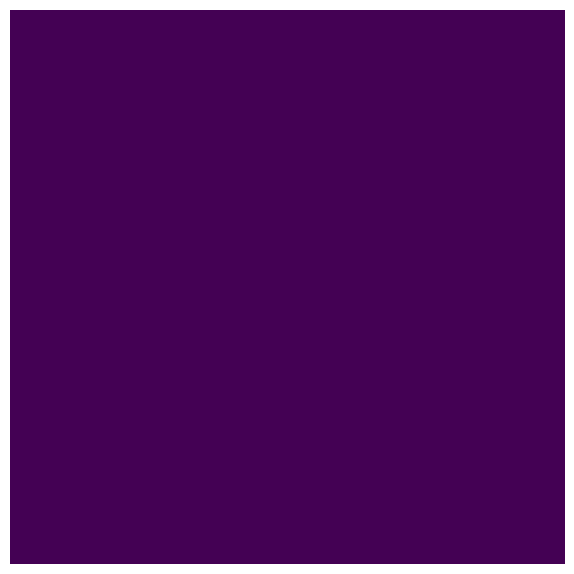

In [33]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(pred_mask, alpha = 1)

#### Impose the mask on the image

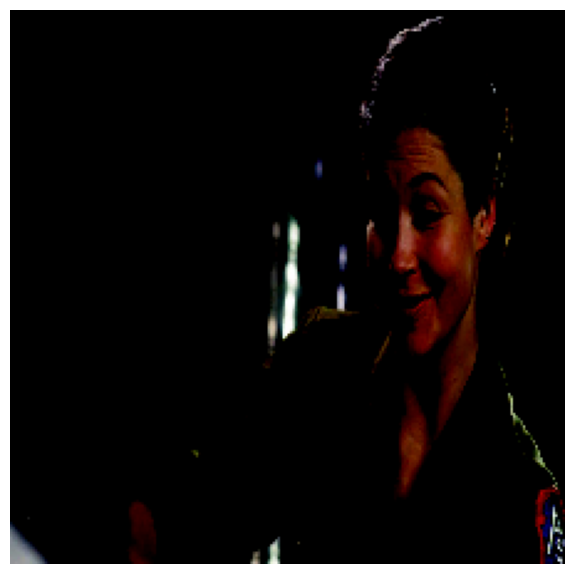

In [34]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(X_test[n])
plt.savefig('image.jpg', bbox_inches = 'tight', pad_inches = 0)

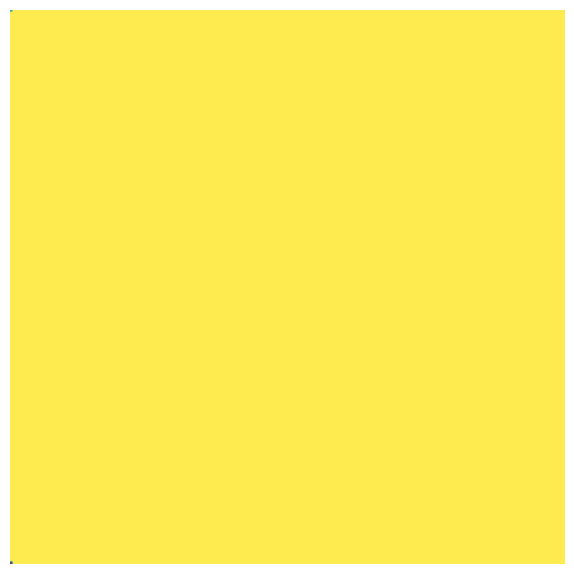

In [35]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(y_pred[n], alpha = 0.8)
plt.savefig('mask.jpg', bbox_inches = 'tight', pad_inches = 0)

The approach we employed for predicting facial boundaries (masks) involved leveraging Transfer Learning. We utilized a pretrained MobileNet model and augmented it with UNET layers to train, fit, and assess the model's performance.
Our model was configured with binary cross-entropy loss, Adam Optimizer for optimization, and Dice Coefficient as the evaluation metric.
Several callbacks were incorporated, including Model Checkpoint, Early Stopping, and ReduceLROnPlateau.
The provided WIDER dataset, a subset of the original, was divided into training and test sets, comprising 400 and 9 images, respectively.
Following 30 epochs of training on the training set, the model achieved a best loss of 0.11 and a Dice Coefficient of 0.95.
Subsequently, we applied the model weights (in this case, model_0.04.h5) to predict facial masks on the test data.
Notably, the model demonstrated efficacy in predicting masks, as illustrated by the example of image 5 in our test dataset.


In [36]:
from zipfile import ZipFile
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

In [37]:
with ZipFile('/content/drive/MyDrive/PINS.zip', 'r') as zip:
  zip.extractall()

In [40]:
import os
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [41]:
def load_image(path):
  img = cv2.imread(path, 1)
  return img[...,::-1]

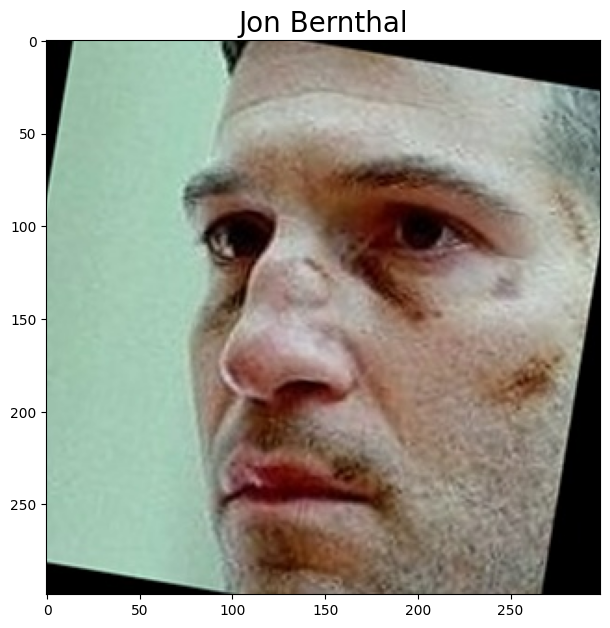

In [42]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

In [57]:
from tensorflow.keras.models import Sequential

def vgg_face():
    model = Sequential()
    model.add(tf.keras.layers.ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.Convolution2D(4096, (7, 7), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Convolution2D(4096, (1, 1), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Convolution2D(2622, (1, 1)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Activation('softmax'))
    return model

In [58]:

model = vgg_face()
model.load_weights('/content/drive/MyDrive/vgg_face_weights.h5')
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_16 (ZeroPad  (None, 226, 226, 3)       0         
 ding2D)                                                         
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 zero_padding2d_17 (ZeroPad  (None, 226, 226, 64)      0         
 ding2D)                                                         
                                                                 
 conv2d_22 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                      

In [59]:
vgg_face_descriptor = Model(inputs = model.layers[0].input, outputs = model.layers[-2].output)

In [61]:
# Get embedding vector for the first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 1s 580ms/step
(2622,)


In [63]:
embeddings = []
embeddings = np.zeros((metadata.shape[0], 2622))
from tqdm.notebook import tqdm
for i, meta in tqdm(enumerate(metadata)):
  try:
    image = load_image(str(meta))
    image = (image / 255.).astype(np.float32)
    image = cv2.resize(image, (224, 224))
    embeddings[i] = vgg_face_descriptor.predict(np.expand_dims(image, axis = 0))[0]
  except:
    embeddings[i] = np.zeros(2622)

0it [00:00, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 1s 586ms/step


In [64]:
def distance(emb1, emb2):
  return np.sum(np.square(emb1 - emb2))

In [65]:
def show_pair(idx1, idx2):
  plt.figure(figsize = (8, 3))
  plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
  plt.subplot(121)
  plt.imshow(load_image(metadata[idx1].image_path()))
  plt.subplot(122)
  plt.imshow(load_image(metadata[idx2].image_path()))

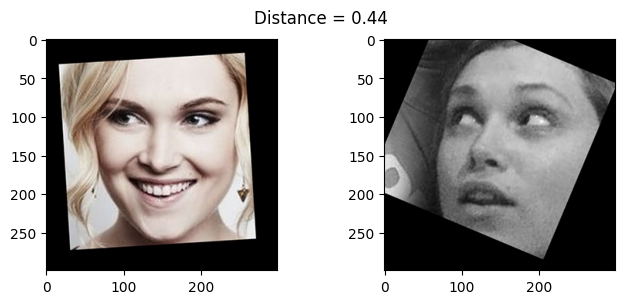

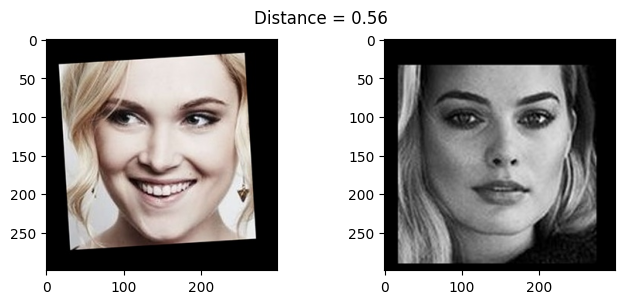

In [66]:
show_pair(2, 3)
show_pair(2, 180)

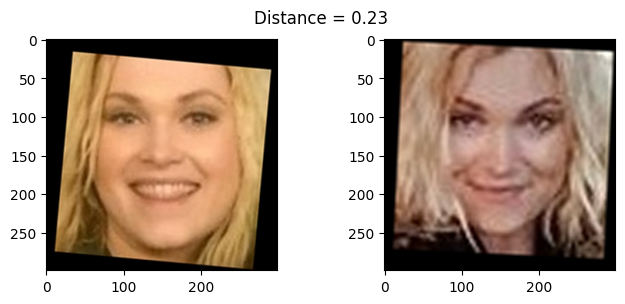

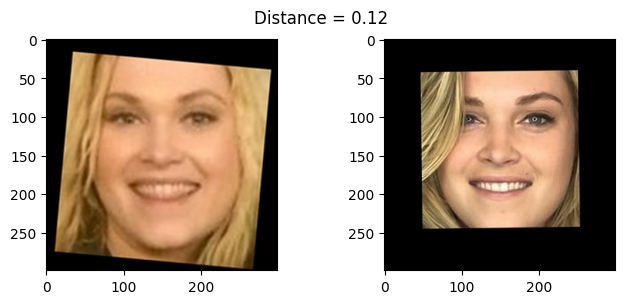

In [67]:
show_pair(30, 31)
show_pair(30, 100)

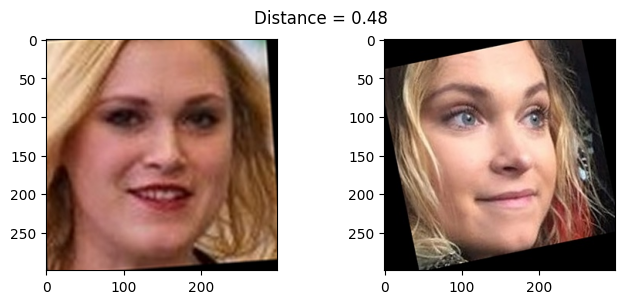

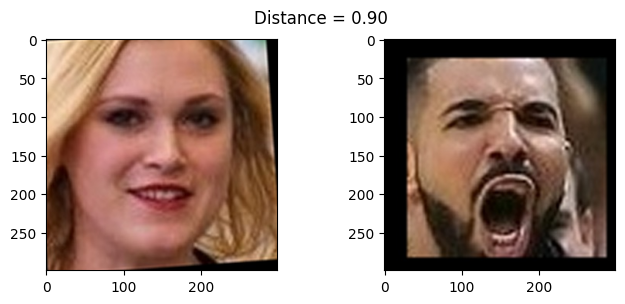

In [68]:
show_pair(70, 72)
show_pair(70, 115)

In [69]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9573, 2622)

(9573,)

(1197, 2622)

(1197,)

In [70]:
encoder = LabelEncoder()
y_train_en = encoder.fit_transform(y_train)
y_test_en = encoder.transform(y_test)

In [71]:
standard_scale = StandardScaler()
X_train_stand = standard_scale.fit_transform(X_train)
X_test_stand = standard_scale.transform(X_test)

In [72]:
cov_matrix = np.cov(X_train_stand.T)
print('The shape of covariance matrix is:', cov_matrix.shape)
print('The covariance matrix is:\n', cov_matrix)

The shape of covariance matrix is: (2622, 2622)
The covariance matrix is:
 [[ 1.00010447  0.11175793  0.1090968  ...  0.07680557 -0.12665378
  -0.25197838]
 [ 0.11175793  1.00010447  0.23351293 ... -0.04570067  0.28396935
   0.2155568 ]
 [ 0.1090968   0.23351293  1.00010447 ... -0.11214636  0.06627869
   0.0360158 ]
 ...
 [ 0.07680557 -0.04570067 -0.11214636 ...  1.00010447 -0.02538396
  -0.0913252 ]
 [-0.12665378  0.28396935  0.06627869 ... -0.02538396  1.00010447
   0.39985446]
 [-0.25197838  0.2155568   0.0360158  ... -0.0913252   0.39985446
   1.00010447]]


In [73]:
eigen_values, eigen_vectors = np.linalg.eig(cov_matrix)
print('The Eigen Vectors are:\n', eigen_vectors)
print('\nThe Eigen Values are:\n', eigen_values)

The Eigen Vectors are:
 [[-0.02379753  0.02036955 -0.00282831 ...  0.01331872 -0.01492106
  -0.00196642]
 [ 0.0090582  -0.00121039 -0.0015208  ... -0.00440971  0.00404618
   0.02432196]
 [-0.00319736  0.00793597  0.00786482 ...  0.01403869 -0.01279095
   0.01390259]
 ...
 [-0.00837394 -0.02297706 -0.00993513 ... -0.02482128 -0.04410012
   0.0156914 ]
 [ 0.0212793  -0.00416237  0.00169573 ...  0.00220362  0.00381148
  -0.01040088]
 [ 0.03878074  0.01062535  0.01711486 ... -0.02493943 -0.02638759
   0.02093959]]

The Eigen Values are:
 [3.56896545e+02 1.41511146e+02 1.03839978e+02 ... 1.59080486e-03
 1.58325104e-03 1.57662098e-03]


In [74]:
total = sum(eigen_values)
variance_exp = [(i / total) * 100 for i in sorted(eigen_values, reverse = True)]
cummulative_variance_exp = np.cumsum(variance_exp)
print('Cumulative Variance Explained:\n', cummulative_variance_exp)

Cumulative Variance Explained:
 [ 13.61019311  19.00669819  22.96661927 ...  99.99999983  99.99999999
 100.        ]


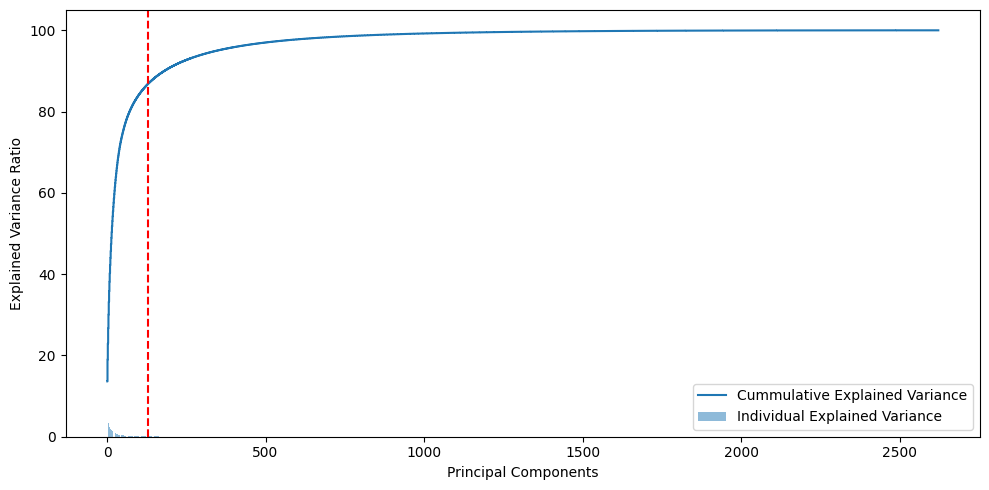

In [75]:
plt.figure(figsize = (10, 5))
plt.bar(range(1, eigen_values.size + 1), variance_exp, alpha = 0.5, align = 'center', label = 'Individual Explained Variance')
plt.step(range(1, eigen_values.size + 1), cummulative_variance_exp, where = 'mid', label = 'Cummulative Explained Variance')
plt.axvline(x = 128, color = 'r', linestyle = '--')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [76]:
pca = PCA(n_components = 128, svd_solver = 'full', whiten = True)
pca.fit(X_train_stand)

X_train_pca = pca.transform(X_train_stand)
X_test_pca = pca.transform(X_test_stand)

display(X_train_pca.shape, X_test_pca.shape)

(9573, 128)

(1197, 128)

The best classifier is:  SVC(C=10.0, class_weight='balanced', gamma=0.01)


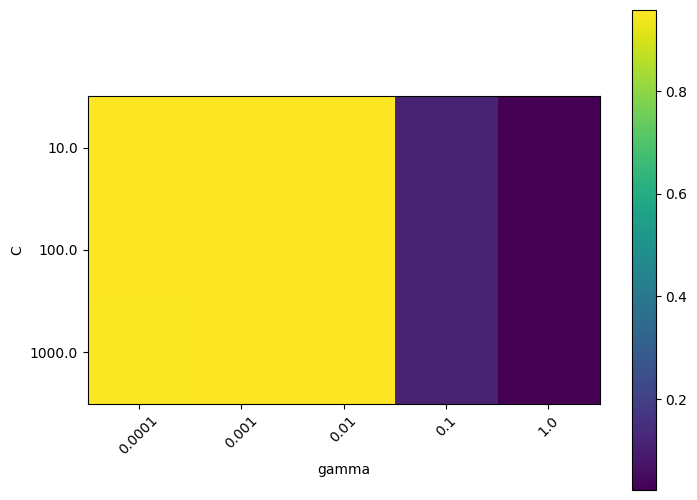

In [77]:
C_range = 10. ** np.arange(1,4)
gamma_range = 10. **np.arange(-4,1)

param_grid = dict(gamma = gamma_range, C = C_range)

grid = GridSearchCV(SVC(class_weight = 'balanced'), param_grid = param_grid, cv = StratifiedKFold(n_splits = 5))

grid.fit(X_train_pca, y_train_en)
print('The best classifier is: ', grid.best_estimator_)

score_dict = grid.cv_results_

scores = score_dict.get('mean_test_score')
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest')
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.show()

In [78]:
svc_model = SVC(C=10.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
svc_model.fit(X_train_pca, y_train_en)

SVC(C=10.0, class_weight='balanced', gamma=0.001)

In [79]:
pred_svm = svc_model.predict(X_test_pca)

In [80]:
print('Accuracy obtained from the model: {}'.format(accuracy_score(y_test_en, pred_svm).round(3)))

Accuracy obtained from the model: 0.963


In [81]:
names = [name.split('_')[1].title().strip() for name in labels]
print('Classification Report: \n{}'.format(classification_report(y_test_en, pred_svm, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      0.90      0.95        10
      Alexandra Daddario       0.91      1.00      0.95        10
            Alvaro Morte       1.00      0.85      0.92        13
Alycia Debnam Carey Face       1.00      1.00      1.00        13
             Amanda Crew       1.00      1.00      1.00         8
          Amaury Nolasco       1.00      0.89      0.94         9
        Amber Heard Face       1.00      0.86      0.92         7
               Anna Gunn       0.93      0.93      0.93        15
           Anne Hathaway       0.92      0.92      0.92        13
     Barbara Palvin Face       1.00      1.00      1.00         8
      Bellamy Blake Face       0.93      1.00      0.97        14
    Benedict Cumberbatch       0.92      1.00      0.96        12
            Betsy Brandt       1.00      1.00      1.00         9
              Bill Gates       1.00      1.00      

Text(0.5, 1.0, 'Identified as pins_eliza taylor')

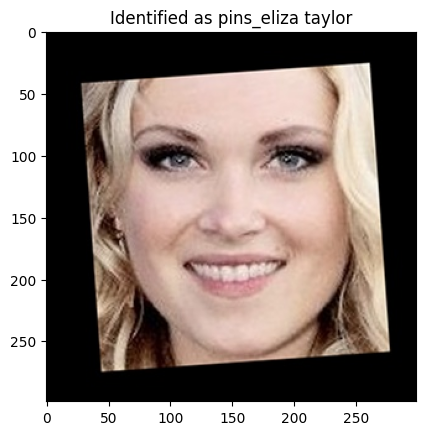

In [82]:
example_idx = 10

example_image = load_image(metadata[test_idx][example_idx].image_path())

#transforming the embedding of the 10th image
example_prediction = svc_model.predict([X_test_pca[example_idx]])

#inverse transformation of the 10th image
example_identity = encoder.inverse_transform(example_prediction)[0]
plt.imshow(example_image)

#the image belongs to which person
plt.title(f'Identified as {example_identity}')

In [83]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = standard_scale.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_model.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = encoder.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 [==============================] - 1s 580ms/step


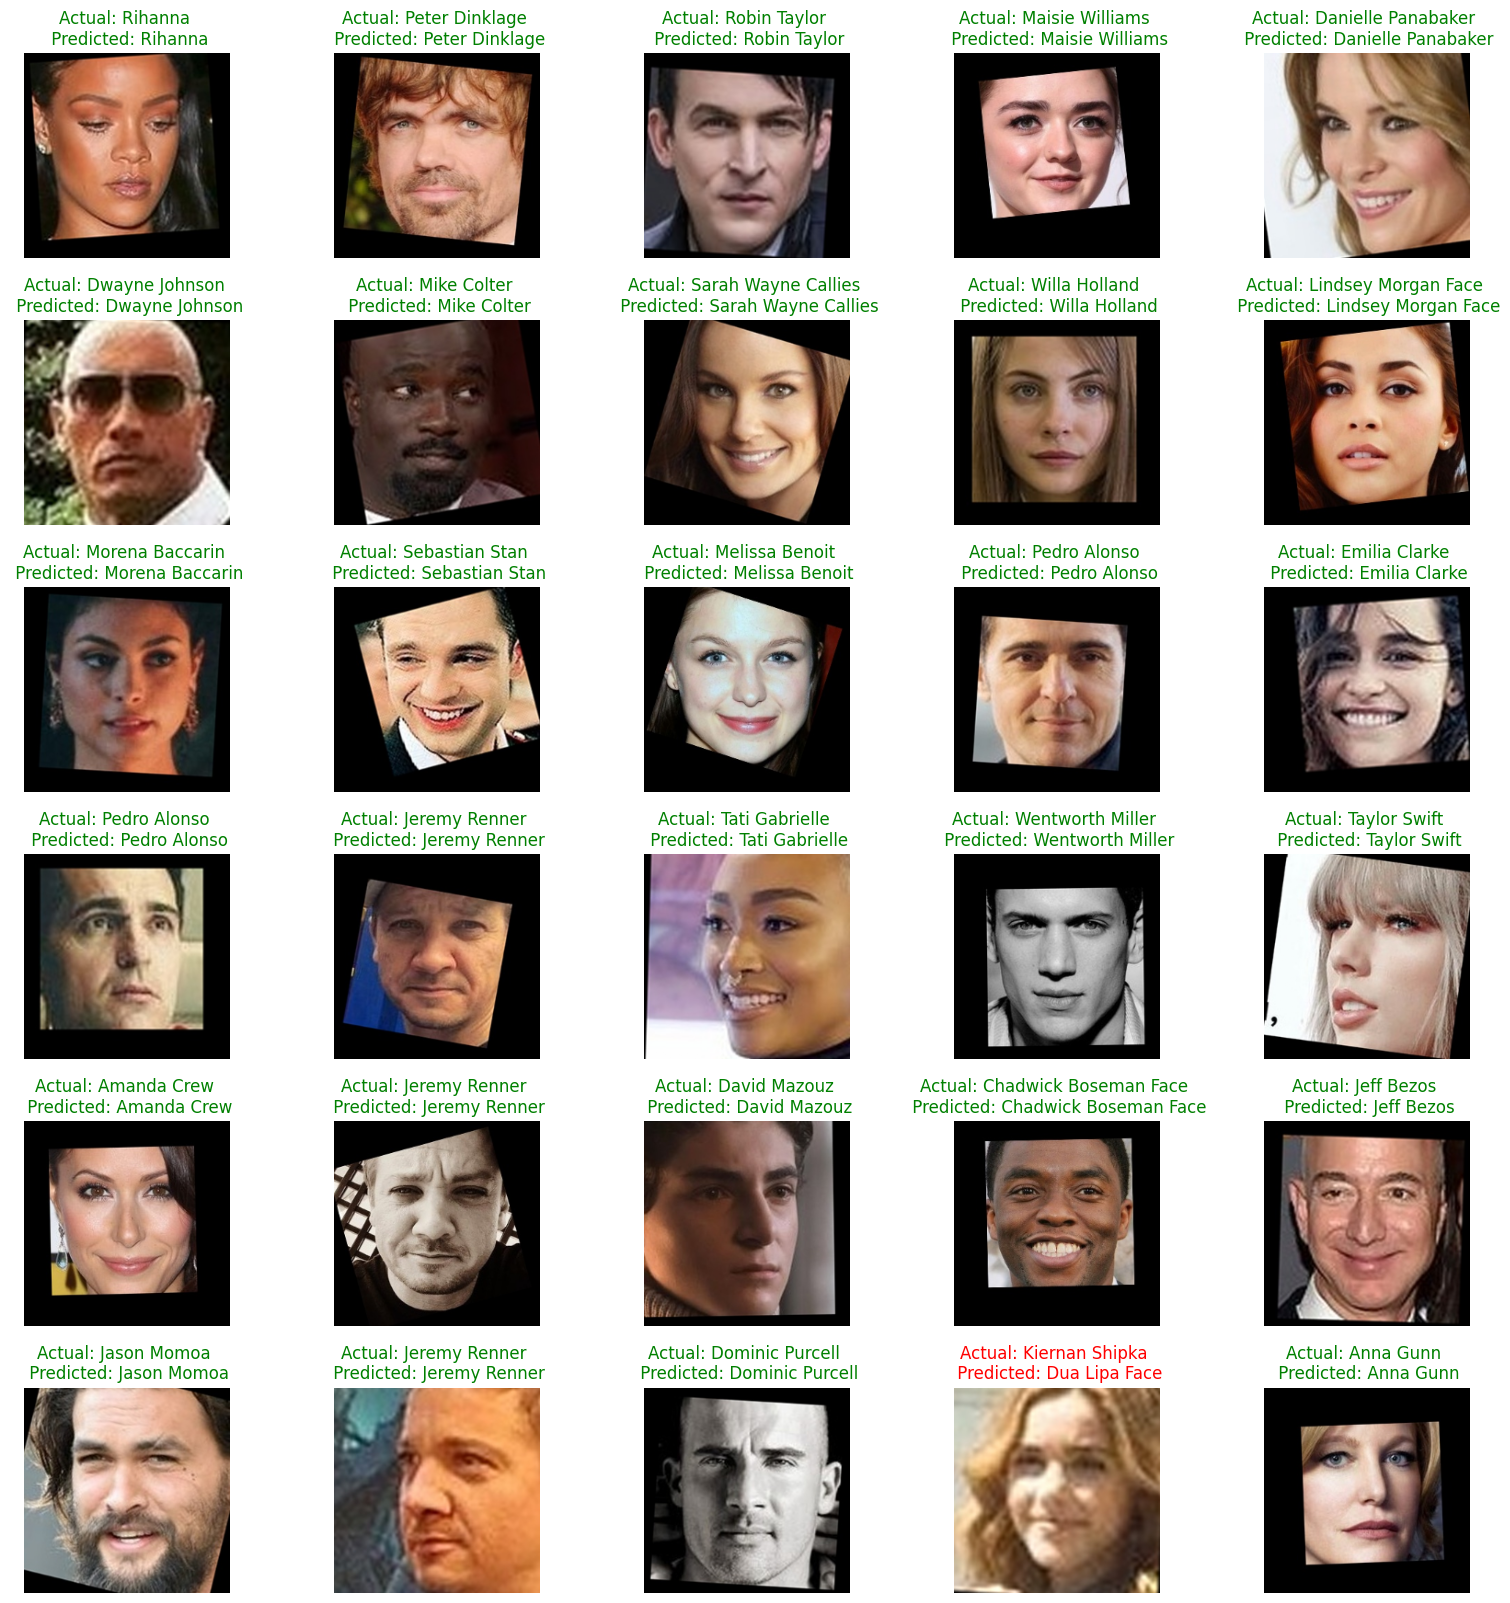

In [86]:
# Random 30 sample images from test data
import matplotlib.gridspec as gdspec
import random
random.seed(0)
plt.figure(figsize = (20, 20))
gs1 = gdspec.GridSpec(6, 5)
gs1.update(wspace = 0, hspace = 0.3)

for i in range(30):
  ax1 = plt.subplot(gs1[i])
  plt.axis('on')
  ax1.set_xticklabels([])
  ax1.set_yticklabels([])
  ax1.set_aspect('equal')

  sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))

  plt.axis('off')
  plt.imshow(sample_img)

  plt.title(f"Actual: {actual_name} \n Predicted: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()